In [1]:
import os

In [2]:
os.environ['KAGGLE_USERNAME'] = 'hyeongjin76' # username
os.environ['KAGGLE_KEY'] = "0955cb26f84373bb42374f7fbd72c45d"

In [3]:

!kaggle datasets download -d tongpython/cat-and-dog
!unzip -q cat-and-dog.zip

 95% 206M/218M [00:01<00:00, 219MB/s]
100% 218M/218M [00:01<00:00, 203MB/s]


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'validation': transforms.Compose({
        transforms.Resize((224,224)),
        transforms.ToTensor()
    })
}

In [6]:
def target_transforms(target):
    return torch.FloatTensor([target])

In [7]:
image_datasets = {
    'train' : datasets.ImageFolder('training_set', data_transforms['train'], target_transform=target_transforms),
    'validation' : datasets.ImageFolder('test_set', data_transforms['validation'], target_transform=target_transforms)
}

dataloaders = {
    'train' : DataLoader(
        image_datasets['train'],
        batch_size=32,
        shuffle=True
    ),
    'validation': DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=False
    )
}

In [8]:
print(len(image_datasets['train']),len(image_datasets['validation']))

8005 2023


In [9]:
model = models.resnet50(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 236MB/s]


In [10]:
for param in model.parameters():
    param.requires_grad = False # 가져온 파라미터(w, b)를 업데이트 하지 않음

model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
epochs = 10
for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        sum_losses = 0
        sum_accs = 0
        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch
            y_batch = y_batch
            y_pred = model(x_batch)
            loss = nn.BCELoss()(y_pred, y_batch)
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            sum_losses = sum_losses + loss.item()
            y_bool = (y_pred >= 0.5).float()
            acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
            sum_accs = sum_accs + acc.item()
        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])
        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')

KeyboardInterrupt: ignored

In [14]:
model.load_state_dict(torch.load('model.h5'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

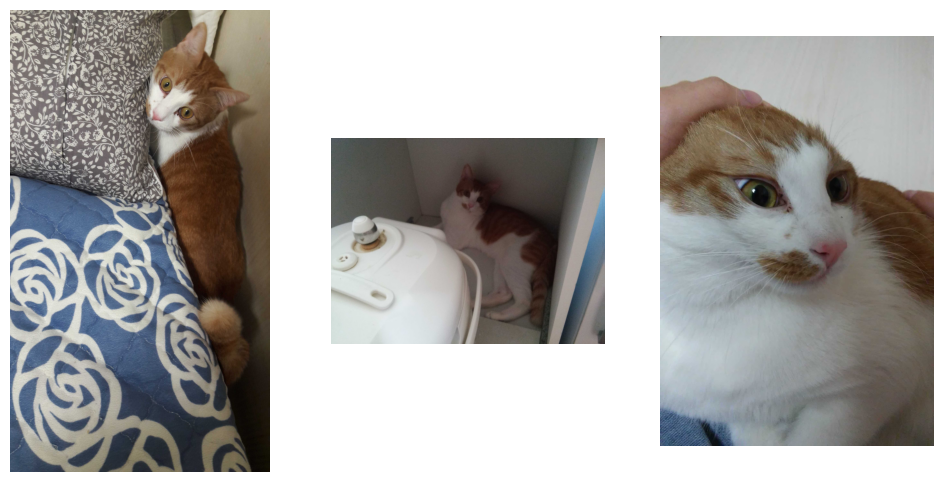

In [34]:
# 테스트
from PIL import Image

img1 = Image.open('1.jpg')
img2 = Image.open('2.jpg')
img3 = Image.open('3.jpg')
img4 = Image.open('4.jpg')
img5 = Image.open('IMG_2815.jpg')


fig, axes = plt.subplots(1, 3, figsize=(12,6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
axes[2].imshow(img3)
axes[2].axis('off')

plt.show()

In [35]:
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)
img3_input = data_transforms['validation'](img3)
img4_input = data_transforms['validation'](img4)
img5_input = data_transforms['validation'](img5)
print(img1_input.shape)
print(img2_input.shape)
print(img3_input.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [36]:
test_batch = torch.stack([img1_input, img2_input,img3_input, img4_input, img5_input])

test_batch = test_batch.to(device)
test_batch.shape

torch.Size([5, 3, 224, 224])

In [24]:
model = model.to(device)

In [37]:
y_pred = model(test_batch)
y_pred

tensor([[2.9558e-02],
        [3.0316e-02],
        [5.8700e-04],
        [8.5248e-01],
        [3.7214e-01]], device='cuda:0', grad_fn=<SigmoidBackward0>)

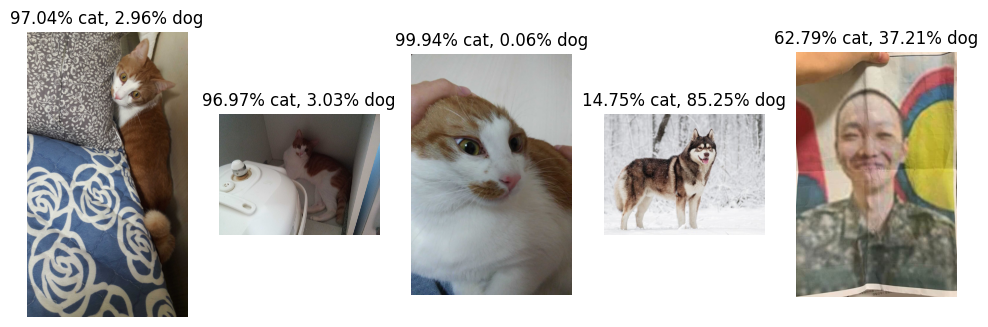

In [38]:
fig, axes = plt.subplots(1, 5, figsize=(12,6))

axes[0].set_title(f'{(1-y_pred[0,0]) * 100:.2f}% cat, {y_pred[0,0] * 100:.2f}% dog')
axes[0].imshow(img1)
axes[0].axis('off')

axes[1].set_title(f'{(1-y_pred[1,0]) * 100:.2f}% cat, {y_pred[1,0] * 100:.2f}% dog')
axes[1].imshow(img2)
axes[1].axis('off')

axes[2].set_title(f'{(1-y_pred[2,0]) * 100:.2f}% cat, {y_pred[2,0] * 100:.2f}% dog')
axes[2].imshow(img3)
axes[2].axis('off')

axes[3].set_title(f'{(1-y_pred[3,0]) * 100:.2f}% cat, {y_pred[3,0] * 100:.2f}% dog')
axes[3].imshow(img4)
axes[3].axis('off')

axes[4].set_title(f'{(1-y_pred[4,0]) * 100:.2f}% cat, {y_pred[4,0] * 100:.2f}% dog')
axes[4].imshow(img5)
axes[4].axis('off')


plt.show()